# P9 - Réalisez une application de recommandation de contenu

#### Installations et imports

In [1]:
# Libraries installation
# from src.libraries_install import *

# Global variables
from src.global_vars import * # import global variables

# Libraries import 
from src.libraries import *

# Functions import
from src.functions import *

# Ignore warnings
# warnings.filterwarnings("ignore")

# PEP8 convention
# %load_ext nb_black
# %load_ext pycodestyle_magic
# %pycodestyle_on

## 2. Jeu de données

Les données analysées dans le notebook P9_Data_exploration sont réimportées dans cette section.

In [2]:
# Upload articles_metadata file
articles_metadata = pd.read_csv('data/articles_metadata.csv')
articles_metadata['creation date'] = pd.to_datetime(articles_metadata['created_at_ts'], unit='ms').dt.date

In [3]:
# Upload or concatenate clic files
folder_path ='data\clicks\clicks'
merged_file_name = 'data\merged_clicks.csv'
if os.path.isfile(merged_file_name):
    clicks = pd.read_csv(merged_file_name)
else:
    clicks = merge_csv_files(folder_path, merged_file_name)
clicks = clicks.astype('int64')
clicks['click_time'] = pd.to_datetime(clicks['click_timestamp'], unit='ms') #.dt.date
clicks = clicks.drop(
        columns=['session_start','session_id',
                 'click_environment','click_os','click_referrer_type',
                 'click_deviceGroup','click_region','click_country'])
clicks['click_time'] = pd.to_datetime(clicks['click_time'])

In [4]:
# Upload articles_embeddings file
articles_embeddings = pd.read_pickle('data/articles_embeddings.pickle')

In [5]:
# Dataset users
var = 'user_id'
df_user = clicks.groupby(var).agg({
    'click_article_id':'count',
    'session_size':'max', # median
    'click_time':'last'})

df_user = df_user.rename(columns={'session_size':'largest_session_by_user',# average session size
                                  'click_time':'last_clic_by_user',
                                  'click_article_id':'total_clics_by_user'
                                           })
df_user['total_articles_by_user'] = clicks.groupby(var).agg({'click_article_id':'unique'})['click_article_id']
df_user['total_articles_by_user'] = df_user['total_articles_by_user'].apply(lambda x: len(x))

In [6]:
# Dataset consulted articles
var = 'click_article_id'
df_article = clicks.groupby(var).agg({
    'user_id':'count',
    'click_time':'last'})
df_article = df_article.rename(columns={'click_time':'last_click_by_article',
                                        'user_id':'total_clics_by_article',
                                           })
df_article['total_readers'] = clicks.groupby(var).agg({'user_id':'unique'})['user_id']
df_article['total_readers'] = df_article['total_readers'].apply(lambda x: len(x))

In [7]:
# Dataset user_article interactions
var = ['user_id','click_article_id']
user_article = clicks.groupby(var,as_index=False).agg(
    user_id=('user_id','first'),
    click_article_id=('click_article_id','first'),
    clics_by_ua=('click_article_id','count'), # Nombre de clics par article (toutes sessions confondues)
    largest_session_by_ua=('session_size','max'),# plus large taille de session lorsque l'article est consulté
    last_clic_by_ua=('click_time','last')) # Dernier clic sur l'article
user_article = user_article.merge(df_user, on = 'user_id', how = 'left')
user_article = user_article.merge(df_article, on = 'click_article_id', how = 'left')

## 3. Modélisation du système de recommandation

Deux approches sont considérées pour la conception du système de recommandation :
- **content-based** : cette méthode se base sur les préférences du lecteur calculées selon ses lectures précédentes. Elle permet une recommandation d’**articles similaires aux articles consommés par le lecteur**;
- **collaboratif-filtering**: cette méthode repose sur l'hypothèse que des lecteurs similaires seront intéressés par les mêmes articles. Elle permet ainsi une recommandation d'articles basés non sur des articles déjà consultés par le lecteur mais sur les **lectures de lecteurs similaires**.

### 3.1 Approche content-based

#### Mesure de similarité cosinus

L'approche dite content-based repose sur le calcul d'une mesure de similarité entre deux articles représentés par des vecteurs d'embeddings.

La matrice d'embeddings fournie dans le jeu de données permet en effet  de représenter près de 3 millions d'articles dans un espace vectoriel de dimension 250. 

Le mesure choisie est le coefficient de **cosin similarity** (similarité cosinus), d'autant plus grand que l'angle (et donc la similarité des vecteurs) est petit.

#### Démarche de recommandation 

La démarche générale de recommandation d'articles avec l'approche content-based se compose ainsi de plusieurs étapes :
- choix de l'utilisateur (user_id) pour lequel la recommandation est réalisée ;
- sélection de l'article de référence sur lequel sera basée la recommandation. Au choix : 
    - article au hasard parmi ceux consultés par le lecteur;
    - dernier article consulté (ancienneté);
    - article le plus consulté (nombre de clics); si plusieurs, le plus récent; 
- calcul pour chaque article non consulté du coefficient de cosin similarity avec l'article de référence;
- recommandations des 5 articles présentant les plus grandes valeurs de coefficient.

#### Visualisation interactive des résultats

Le diagramme suivant permet de visualiser les résultats de recommandation pour un utilisateur et un mode de sélection de l'article de référence au choix :

In [47]:
# Content-based recommendation for a chosen user
@interact(
    idx=widgets.IntSlider(min=0, max=len(clicks['user_id'].unique()),
                          step=1, value=57288,
                          description="User Id :"),
    option=widgets.Dropdown(options=['most clicked', 'last','random'], value='most clicked', description='Reference article :'),
    )

def show_data(idx,option):

    # 0. Get user_id

    user_id = idx
    print("SELECTED USER")
    print(f"User id : {user_id}")

    # 1. Get reference article based on metier preference

    print('--')    
    print('REFERENCE ARTICLE USED FOR RECOMMENDATION')
    article_id = select_article(option,clicks,user_id)
    
    display(articles_metadata[articles_metadata['article_id']==article_id].drop(columns=['created_at_ts','publisher_id']))

    # 2. Get other articles read by the user
    print('--')
    print('OTHER ARTICLES READ BY THE USER')
    display(articles_metadata[articles_metadata['article_id'].isin(clicks[clicks['user_id']==user_id]['click_article_id'])].drop(columns=['created_at_ts','publisher_id']))

    ## 3. Compute cosin similarity of the reference article with those of the embedding matrix  & get recos

    df_articles_embeddings = pd.DataFrame(articles_embeddings, columns=["embedding_" + str(i) for i in range(articles_embeddings.shape[1])])
    recos = get_cosinsimilarity(df_articles_embeddings,article_id)
    print('--')    
    print(f"RECOMMENDED ARTICLES : {recos}")

    display(articles_metadata.loc[recos].drop(columns=['created_at_ts','publisher_id']))


interactive(children=(IntSlider(value=57288, description='User Id :', max=322897), Dropdown(description='Refer…

#### 3.2 Approche collaborative featuring

L'approche dite de collaborative filtering (ou filtrage collaboratif) part de l'hypothèse que des lecteurs similaires sont intéressés par les mêmes articles. 

Elle propose ainsi de baser ses recommandations sur les préférences de ces lecteurs plutôt que simplement sur les lectures individuelles. 

Pour chaque lecteur, chaque article consulté est d'abord évalué par une **note lecteur-article** sur la base de son historique de lecture.

Un **algorithme de filtrage collaboratif** est ensuite utilisé pour identifier les lecteurs aux goûts similaires et (ré)attribuer une note à toutes les paires article-lecteur. 

L'algorithme entrainé permet alors de prédire, pour un lecteur donné, une note à tous les articles non préalablement consultés et de fournir ainsi des recommandations.  

#### Démarche de recommandation 

La démarche générale de recommandation d'articles avec l'approche de filtrage collaboratif diffère partiellement de celle basée sur le contenu :
- sélection de l'utilisateur (user_id) pour lequel la recommandation est réalisée ;
- prédiction par l'algorithme de filtrage collaboratif d'une note pour chaque article non consulté; 
- recommandation des 5 articles présentant les meilleures notes.

#### Note lecteur-article 

Trois types de notes sont évalués pour les couples utilisateur-article :
- **Nombre de clics** 
- **Nombre de clics / Nombre de clics total effectués par l'utilisateur**; cette note permet d'estimer l'importance relative de l'article pour l'utilisateur par rapport au nombre de clics effectués sur l'ensemble des autres articles consultés.
- **Nombre de clics / Taille de session maximale lorsque l'article est consulté**; cette dernière note permet d'indiquer l'intérêt de l'utilisateur en fonction du nombre de clics sur l'article relativement au temps passé dessus. Si la taille de session maximale est petite, cela signifie que l'utilisateur a probablement passé un temps plus significatif sur l'article que si la taille de session était grande et qu'il avait partagé son temps entre plusieurs autres articles.

In [9]:
# Preview of all variables that could be used to define a rate
user_article.drop(columns=['user_id','click_article_id','last_clic_by_ua','last_click_by_article']).head(5)

,clics_by_ua,largest_session_by_ua,total_clics_by_user,largest_session_by_user,last_clic_by_user,total_articles_by_user,total_clics_by_article,total_readers
0,1,2,8,2,2017-10-09 01:54:46.617,8,1500,1491
1,1,2,8,2,2017-10-09 01:54:46.617,8,1344,1334
2,1,2,8,2,2017-10-09 01:54:46.617,8,4885,4812
3,1,2,8,2,2017-10-09 01:54:46.617,8,5967,5930
4,1,2,8,2,2017-10-09 01:54:46.617,8,368,364


In [10]:
# Define a rate for each user-article pair
rates = user_article[['user_id','click_article_id','clics_by_ua']].copy()
rates['user_clic_ratio'] = user_article['clics_by_ua'] / user_article['total_clics_by_user'] # click ratio de l'utilsateur sur l'article
rates['clics_per_session'] = user_article['clics_by_ua'] / user_article['largest_session_by_ua'] # click
rates.head(10)

,user_id,click_article_id,clics_by_ua,user_clic_ratio,clics_per_session
0,0,68866,1,0.125000,0.5
1,0,87205,1,0.125000,0.5
2,0,87224,1,0.125000,0.5
3,0,96755,1,0.125000,0.5
4,0,157541,1,0.125000,0.5
5,0,160158,1,0.125000,0.5
6,0,233470,1,0.125000,0.5
7,0,313996,1,0.125000,0.5
8,1,36162,1,0.083333,0.5
9,1,59758,1,0.083333,0.5


##### Visualisation des notes

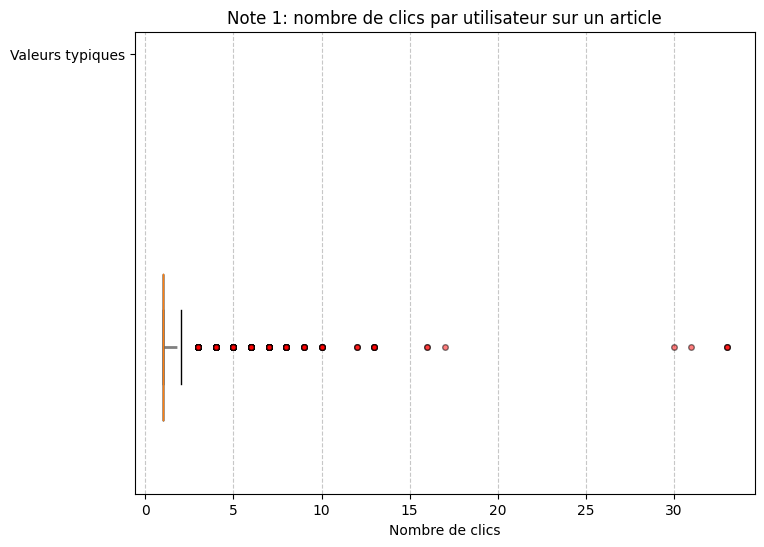

In [11]:
visualize_histogram(rates["clics_by_ua"], "Note 1: nombre de clics par utilisateur sur un article", "Nombre de clics", 'data/figs/rate_1.png')

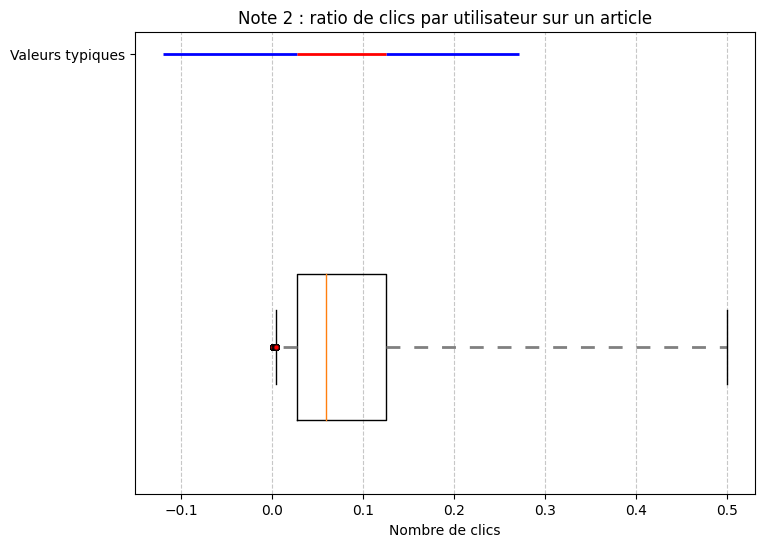

In [12]:
visualize_histogram(rates["user_clic_ratio"], "Note 2 : ratio de clics par utilisateur sur un article", "Nombre de clics", 'data/figs/rate_2.png')

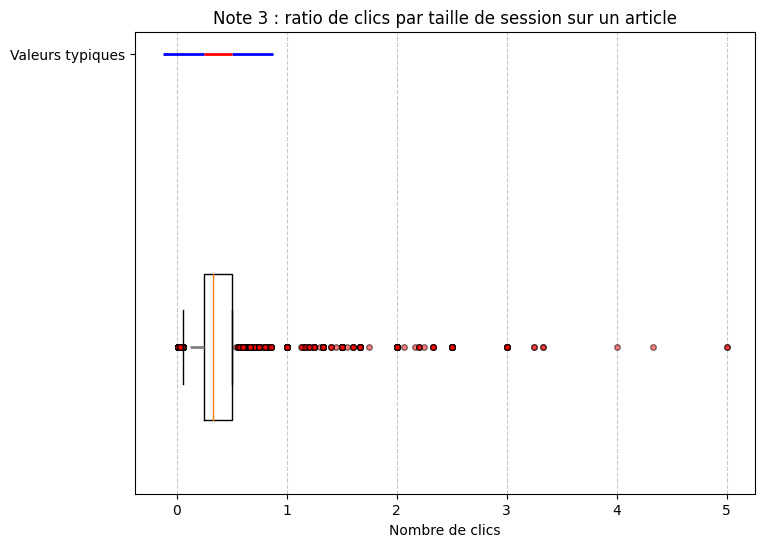

In [13]:
visualize_histogram( rates["clics_per_session"], "Note 3 : ratio de clics par taille de session sur un article", "Nombre de clics", 'data/figs/rate_3.png')

Le **ratio de clics par session** sur chaque article semble être la meilleure option car elle possède la plus grande variabilité de valeurs.

#### Algorithme de filtrage collaboratif SVD

Plusieurs variantes des algorithmes de filtrage collaboratif existent, notamment :
- User-based collaborative filtering : les évaluations passées des utilisateurs permettent de recommander des articles similaires à d'autres utilisateurs ayant des goûts similaires;
- Item-based collaborative filtering : la mesure de similarité est effectuée sur les articles plutôt que les utilisateurs;
- Matrix factorization: la matrice des évaluations article-utilisateur est décomposée en deux matrices de facteurs latents. Ces facteurs sont utilisés pour prédire les notes des articles non évalués;
- SVD (singular value decomposition) : la matrice des évaluations est décomposée en trois matrices, une matrice de vecteurs singuliers gauche, une matrice de vecteurs singuliers droit et une matrice diagonale de valeurs singulières.

Le choix de l'algorithme dépend de plusieurs facteurs :
- Si le nombre d'utilisateurs est plus large que le nombre d'articles, l'approche item-based est plus rapide et plus stable. La note moyenne reçue par un article ne change pas aussi rapidement que la note moyenne donnée par un utilisateur à différents articles. Cette approche fonctionne également mieux lorsque la matrice de notes est clairsemée;
- Pour les matrices quasiments vides, une technique de réduction de dimension comme une méthode de factorisation est utilisée pour améliorer les performances de l'algorithme de filtrage.

Dans notre cas, le nombre d'utilisateurs (322 897) est supérieur au nombre d'articles lus (46 033), mais le taux de remplissage de la matrice est de 0.02 % seulement. L'algorithme SVD (Singular Value Decomposition) est privilégié : la technique de factorisation matricielle qu'il utilise permet d'extraires les caractéristiques latentes sous-jacentes entre utilisateurs et articles tout en minimisant les risques de surapprentissage. 

Parmi les hyperparamètres de ce modèle, une attention particulière sera donc portée au nombre de facteurs latents *n_factors*, soit nombre de dimensions dans lesquelles la matrice de données originale est réduite lors de la décomposition en valeurs singulières.

<p align="center">
  <img src="src/svd.png">
  <br>
  <em> Décomposition matricelle d'un algorithme SVD </em>
</p>

[Source](https://towardsdatascience.com/simple-svd-algorithms-13291ad2eef2)

In [55]:
print(f"Nombre d'utilisateurs : {user_article['user_id'].nunique()}")
print(f"Nombre total d'articles consultés : {user_article['click_article_id'].nunique()}")
print(f"Nombre de paires utilisateur-article évaluées : {np.round(1E-6*user_article.shape[0],2)} millions")
print(f"Taille de la matrice user-article : {np.round((1E-9)*(user_article['user_id'].nunique()*user_article['click_article_id'].nunique()),2)} milliards")
print(f"Taux de remplissage de la matrice user-article : {np.round(100*user_article.shape[0]/(user_article['user_id'].nunique()*user_article['click_article_id'].nunique()),2)} %")

Nombre d'utilisateurs : 322897
Nombre total d'articles consultés : 46033
Nombre de paires utilisateur-article évaluées : 2.95 millions
Taille de la matrice user-article : 14.86 milliards
Taux de remplissage de la matrice user-article : 0.02 %


#### Entraînement et évaluation du modèle SVD

La librairie Suprise est utilisée afin de définir et d'entraîner l'algorithme SVD :
- la note sélectionnée pour l'apprentissage est celle correspondant au ratio de clics par taille maximale de session pour un couple lecteur-article ("clics_by_session");
- le paramètre rating_scale (classe Reader) est pris à (0,5), à l'échelle de valeurs prises par les notes;
- les hyperparamètres de l'algorithme SVD sont variés autour de leur valeur par défaut à l'aide d'une fonction Gridsearch CV;
    - **n_factors** (nombre de facteurs latents) : [50, 100, 140];
    - **n_epochs** (nombre d'itérations) : [10, 20, 50];
    - **lr_all** (taux d'apprentissage):[0.002, 0.005, 0.007];
    - **reg_all** (terme de régularisation, ajouté pour éviter le surapprentissage): [0.01, 0.02, 0.03]; 
    - **CV** (nombre de plis) : 3;
    
- Les métriques RMSE (root mean square error) et MAE (mean absolute error) sont utilisées pour l'évaluation des modèles.

In [19]:
# Data prepation for surprise
userId = 'user_id'
articleId = 'click_article_id'
rating = 'clics_per_session' # Note 3
pred_rating = 'pred_' + rating 
data = rates

# Format data for surprise
reader = Reader(rating_scale=(0,5)) # Note 3

data = Dataset.load_from_df(data[[userId, articleId, rating]], reader)

# Choose training type
# training_type = 'simple' 
training_type = 'grid_search'


if training_type == 'simple':
    # Split data into train and test sets
    trainset, testset = train_test_split(data, test_size=0.25, random_state=random_state)
    # trainset = data.build_full_trainset() # to use all data for training
     
    # Train the model
    SVD_model = SVD(n_factors=100, n_epochs=20, random_state=random_state)  
    cross_validate(SVD_model, data, measures=["RMSE", "MAE"], cv=3, verbose=True) # Run 3-fold cross-validation and print results
    # SVD_model.fit(trainset, verbose=True, n_jobs=-1)

    # Predict accuracy
    predictions = SVD_model.test(testset)  
    print('Basic model accuracy :')
    print(f"(rmse) : {accuracy.rmse(predictions)}")
    print(f"(mae): {accuracy.mae(predictions)}")
    print(f"(fcp): {accuracy.fcp(predictions)}")
    print(f"(mse): {accuracy.mae(predictions)}")


elif training_type == "grid_search":
    # grid search parameters
    param_grid = {'n_factors': [50, 100, 140], 'n_epochs': [10, 20, 50], 'lr_all':[0.002, 0.005, 0.007], 'reg_all':[0.01, 0.02, 0.03]} 

    # Train the model
    gs = GridSearchCV(SVD, param_grid, measures=["RMSE", "MAE"], cv=3, n_jobs=-1) # add  to use all cores
    gs.fit(data)

    # best RMSE score and parameters
    print('(Gridsearch-)Optimized model accuracy :')
    print(f"Best RMSE score : {gs.best_score['rmse']}")
    print(f"Best MAE score : {gs.best_score['mae']}")
    print(f"Best hyperparameters (rmse): {gs.best_params['rmse']}")
    print(f"Best hyperparameters (mae) : {gs.best_params['mae']}")
    print(f"Best model (rmse) : {gs.best_estimator['rmse']}")
    print(f"Best model (mae) : {gs.best_estimator['mae']}")

    # Train the best model
    SVD_model = gs.best_estimator['rmse']
    trainset = data.build_full_trainset() # to use all data for training
    SVD_model.fit(trainset)#, verbose=True, n_jobs=-1)

# Get predicted rates for each user-article pair already rated
rates[pred_rating] = rates.apply(lambda x: SVD_model.predict(x['user_id'], x['click_article_id']).est, axis=1) 

(Gridsearch-)Optimized model accuracy :
Best RMSE score : 0.11940757752031621
Best MAE score : 0.09542593981974579
Best hyperparameters (rmse): {'n_factors': 50, 'n_epochs': 50, 'lr_all': 0.007, 'reg_all': 0.03}
Best hyperparameters (mae) : {'n_factors': 50, 'n_epochs': 50, 'lr_all': 0.007, 'reg_all': 0.02}
Best model (rmse) : <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x000001DDE3A84550>
Best model (mae) : <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x000001DEA6E9A5F0>


KeyError: 'RMSE'

##### Métrique d'évaluation

Plusieurs métriques sont utilisées pour évaluer les prédictions. Ces évaluations sont réalisées sur un jeu de test contenant donc des paires article-utilisateur avec déjà une note réelle.
- Erreur RMSE (Root Mean Square Error): moyenne quadratique des erreurs des prediction
- Mean Absolute Error (MAE) : moyenne des valeurs absolues des erreurs

Les valeurs des notes prédites et réelles sont également visualisées pour quelques paires lecteur-article choisies.

##### Visualisation des prédictions 

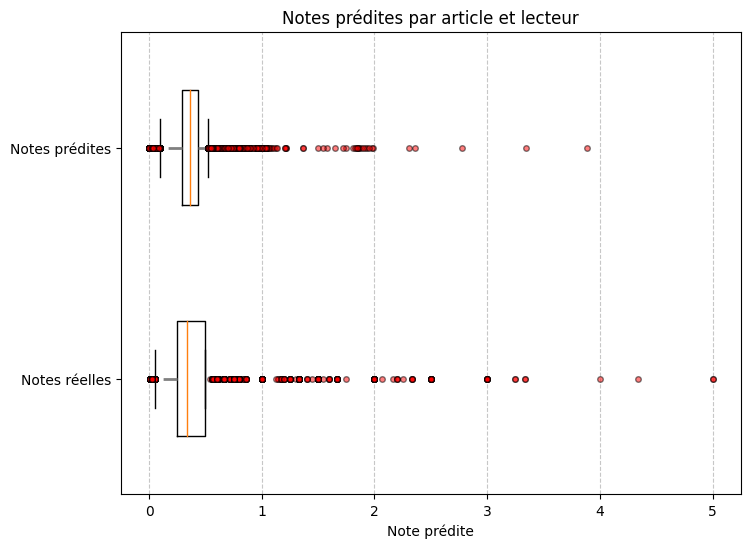

In [56]:
# Plot Boxplots for predicted rates and real rates
fig = plt.figure(figsize=figsize)

# Real rates
bp = plt.boxplot(rates[rating], vert=False, widths=0.5, positions=[0], whis=[1,99])
plt.setp(bp['whiskers'], linestyle='--', color='gray', lw=2, dashes=(5, 5))
plt.setp(bp['fliers'], marker='.', markerfacecolor='red', markersize=8, alpha=0.5)

# Predicted rates
bp = plt.boxplot(rates[pred_rating], vert=False, widths=0.5, positions=[1], whis=[1,99])
plt.setp(bp['whiskers'], linestyle='--', color='gray', lw=2, dashes=(5, 5))
plt.setp(bp['fliers'], marker='.', markerfacecolor='red', markersize=8, alpha=0.5)

# Predicted rates fullset
# bp = plt.boxplot(rates[pred_rating +'_fullset'], vert=False, widths=0.5, positions=[2], whis=[1,99])
# plt.setp(bp['whiskers'], linestyle='--', color='gray', lw=2, dashes=(5, 5))
# plt.setp(bp['fliers'], marker='.', markerfacecolor='red', markersize=8, alpha=0.5)

plt.yticks([0, 1], ["Notes réelles", "Notes prédites"])
#plt.yticks([0, 1, 2], ["Notes réelles", "Notes prédites - Modèle de base", "Notes prédites - Modèle optimisé"])


plt.title("Notes prédites par article et lecteur") 
plt.xlabel("Note prédite")

plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()
fig.savefig('data/figs/real_vs_pred_rates.png', dpi=300, bbox_inches='tight')

In [60]:
# Side by side comparison of real rates and predicted rates for a chosen number of samples
@interact(n_bars=widgets.IntSlider(min=0, max=100,
                          step=1, value=10,
                          description="Nombre d'échantillons :"))   
def show_side_by_side(n_bars):
    width = 0.35  # width of the bars
    
    ind = np.arange(len(rates[rating]))  # indices of the bars
    selected_bars = np.random.choice(ind, n_bars)
    
    fig, ax = plt.subplots()

    # bars with real rates
    rects1 = ax.bar(np.arange(n_bars), rates[rating][selected_bars], width, color='r')

    # bars with predicted rates
    rects2 = ax.bar(np.arange(n_bars) + width, rates[pred_rating][selected_bars], width, color='y')

    # legend and labels
    ax.set_xlabel('Observations')
    ax.set_ylabel('Valeurs')
    ax.legend((rects1[0], rects2[0]), ('Réelles', 'Prédites'))
    ax.set_title(f"Comparaison des notes réelles et prédites pour un échantillon de {n_bars} paires article/lecteur")

    plt.show()
    fig.savefig(f'data/figs/real_vs_pred_rates_rand_{n_bars}usrs.png', dpi=300, bbox_inches='tight')

interactive(children=(IntSlider(value=10, description="Nombre d'échantillons :"), Output()), _dom_classes=('wi…

##### Recommandations

In [62]:
# Recommendation tool for collaborative filtering
@interact(
    idx=widgets.IntSlider(min=0, max=len(clicks['user_id'].unique()),
                          step=1, value=140711,#57288,
                          description="User Id :"))   
def show_data(idx):

    # 0. Get random user_id
    user_id = idx
    print('SELECTED USER : READ ARTICLES')
    print(f"User id : {user_id}")
    display(articles_metadata[articles_metadata['article_id'].isin(
        user_article[user_article['user_id']==idx]['click_article_id'].values)].drop(columns=['created_at_ts','publisher_id']))

    # 1. Predit rates for all the articles for this user_id and get the top 5 most rated articles
    top_recos, recos = get_best_rated_reco(user_id, articles_metadata, rates, SVD_model)
    print('--')    
    print(f"RECOMMENDED ARTICLES : {top_recos}")
    display(recos[recos['article_id'].isin(top_recos)].drop(columns=['predicted_rate','publisher_id']))

interactive(children=(IntSlider(value=140711, description='User Id :', max=322897), Output()), _dom_classes=('…

In [61]:
# Side by side comparison of real rates and predicted rates by user  
@interact(
    idx=widgets.IntSlider(min=min(rates['user_id'].unique()), max=max(rates['user_id'].unique()),
                          step=1, value=140711,#57288,#149963,
                          description="User Id :"))   


def show_side_by_side(idx):
    width = 0.35  # width of the bars
    n_bars = len(rates[rates['user_id']==idx])  # number of bars to plot
    ind = np.arange(n_bars)  # indices of the bars
    
    fig, ax = plt.subplots()

    # bars with real rates
    rects1 = ax.bar(ind, rates[rates['user_id']==idx][rating], width, color='r')

    # bars with predicted rates
    rects2 = ax.bar(ind + width, rates[rates['user_id']==idx][pred_rating], width, color='y')

    # bars with predicted rates fullset
    # rects3 = ax.bar(ind + width*2, rates[rates['user_id']==idx][pred_rating +'_fullset'], width, color='g')

    # legend and labels
    ax.set_xlabel('Observations')
    ax.set_ylabel('Valeurs')
    ax.legend((rects1[0], rects2[0]), ('Réelles', 'Prédites'))# , 'Prédites fullset')) #, rects3[0],
    ax.set_title('Comparaison des notes réelles et prédites pour les articles lus par un utilisateur')

    plt.show()
    fig.savefig(f'data/figs/real_vs_pred_rates_usr{idx}.png', dpi=300, bbox_inches='tight')

interactive(children=(IntSlider(value=140711, description='User Id :', max=322896), Output()), _dom_classes=('…

##### Sauvegarde du modèle final

In [26]:
#### Sauvegarde du modèle

with open('model.pkl', 'wb') as f:
    pickle.dump(SVD_model, f)

#### 3.3 Synthèse des modèles de recommandation

Deux types de modèles de recommandations d'articles ont été testés pour la conception du MVP :
- le modèle content-based a l'avantage de ne pas être limité aux articles lus par l'ensemble des lecteurs, mais il ne recommande que des articles similaires à ceux déjà consultés; 
- le modèle basé sur une approche de filtrage collaboratif permet de recommander des contenus plus originaux pour le lecteur, puisqu'ils sont basés sur les goûts de lecteurs similaires. Il ne permet toutefois pas d'accéder à des articles déjà non consultés. 

Une solution plus intéressante serait de combiner ces deux approches, permettant ainsi au lecteur d'accéder à la fois à une offre de contenu plus large mais aussi plus originale.

### 4. Architecture Serverless

Le principe du Serverless est de pouvoir concevoir des applications sans avoir à penser à la gestion parfois fastidieuse des servers physiques, notamment la configuration du framework Web, le routage et la définition des requêtes.

Le service le plus associé à la fonction Serverless est le service **Azure FaaS dit Azure Functions** (Function as a Service). Son fonctionnement se veut aussi simple qu'un fichier avec une seule méthode, la fonction Azure; cette méthode est appelée avec des déclencheurs ("triggers").

##### Architecture proposée

Il est proposé de mettre en place une architecture implicant une Azure function pour l'appel du sytème de recommandation
- **Azure Function** : une Azure function incluant le jeu de données et un système de recommandation est développée et déployée à partir de VS code vers Azure grâce à une extension dédiée
    - Le jeu de données contient les fichiers bruts téléchargés sur le site Kaggle, hormis pour les clics, qui ont été concaténés
    - Le système de recommandation utilisé pour le déploiement est celui basé sur l'approche content-based, avec un choix aléatoire de l'article de référence parmi ceux consultés par un lecteur
- **Azure Web App**  une application web permet aux utilisateurs d'obtenir une recommandation de 5 articles pour un lecteur donné
    - L'interface web d'interaction avec l'utilisateur est développée sur Flask déployée dans une Azure Web App via Github
    - L'utilisateur entre un identifiant d'utilisateur user_id dans un espace dédié sur cette interface 
    - L'entrée de cet identifant déclenche l'Azure function qui renvoie alors les 5 articles recommandés
    - Ces 5 articles sont affichés dans l'interface

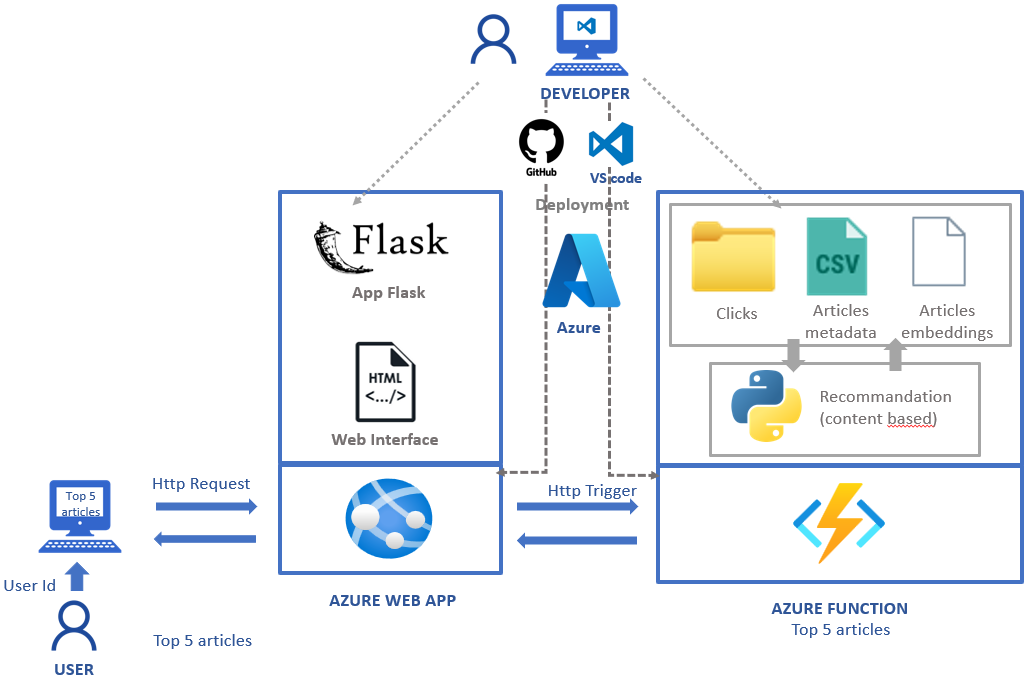

Il aurait été possible d'intégrer le système de recommandation dans une **API** et de stocker les données dans un **blob storage**.

Dans la configuration retenue, il est difficile de mettre à jour les données si de nouveaux clics ou de nouveaux articles doivent être ajoutés. Il faut alors redéployer l'Azure function.

##### Architecture cible 

Une architecture plus adaptée est proposée pour prendre en compte la mise à jour régulière des données.


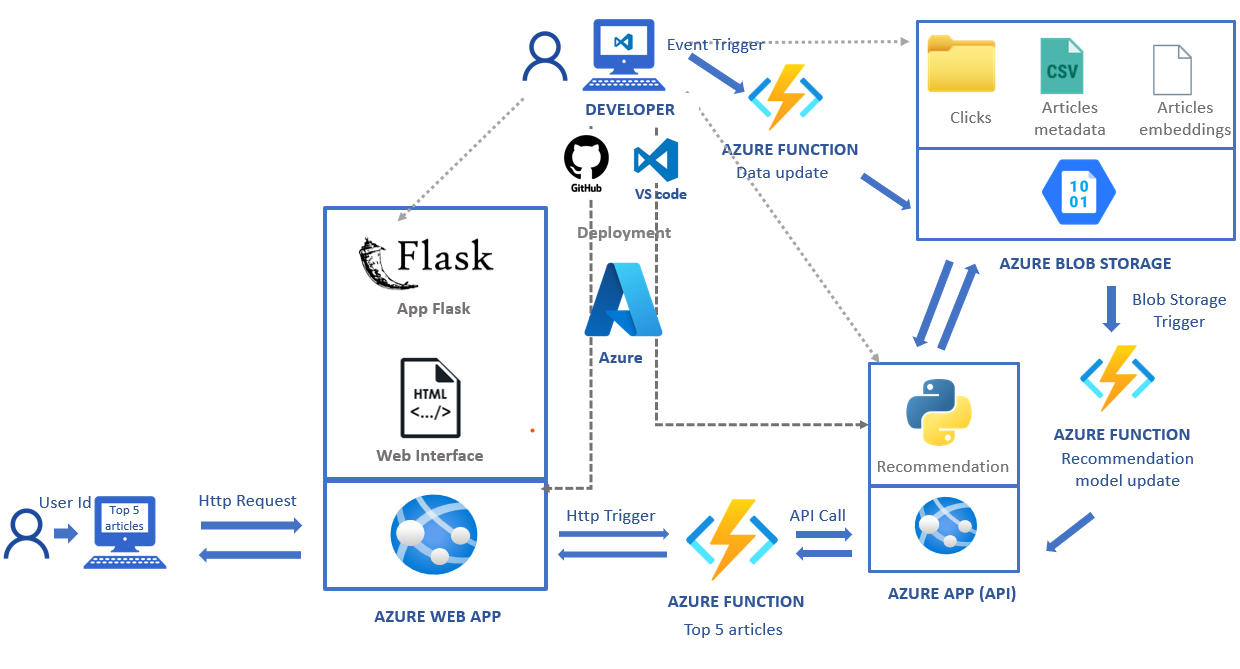